# Init Tdx 

In [104]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

'module://ipympl.backend_nbagg'

In [105]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [106]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [107]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(15.24, '2024-11-22')

(12.76,
 52    2025-02-13
 Name: date, dtype: object)

9 0.32 2.86
Bull
2.86


### regression_line(X, Y)
regression_ratio(df, window=10):

12.9 -0.05
Above
-0.05


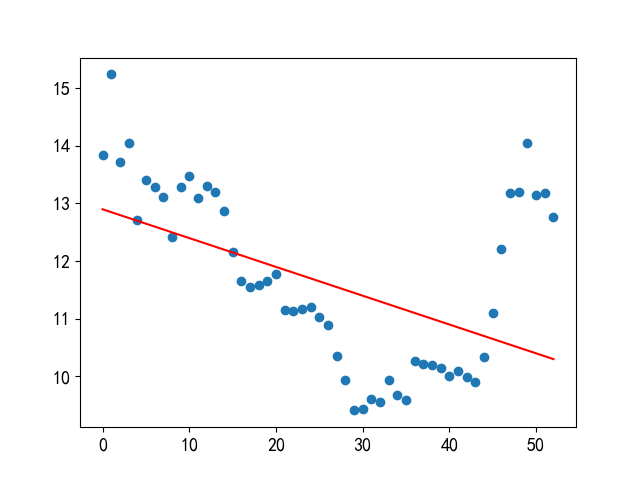

In [108]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

12.9 -0.05
Above
-0.05


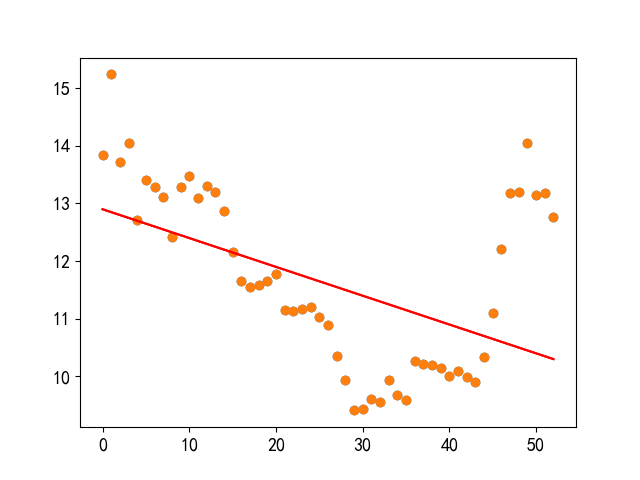

In [109]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [110]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'hmax', 'hmax60', 'high4', 'low4', 'lastdu4', 'macdwhite', 'macdyellow',
       'macdlast1', 'macdlast2', 'macdlast3'],
      dtype='object', length=190)

### check_postion_vol_price

In [111]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code   open   high    low  close          vol        amount  \
52  2025-02-13  601360  13.18  13.28  12.67  12.76  337783988.0  4.362291e+09   

     ma5d  ma10d  ...  hmax60  high4   low4   lastdu4  macdwhite  macdyellow  \
52  13.27  12.31  ...   15.24   14.4  12.63  1.131186       0.56        0.19   

    macdlast1  macdlast2  macdlast3  Positon  
52       0.75       0.92       1.03  Neutral  

[1 rows x 191 columns]

In [112]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'hmax60', 'high4', 'low4', 'lastdu4', 'macdwhite', 'macdyellow',
       'macdlast1', 'macdlast2', 'macdlast3', 'Positon'],
      dtype='object', length=191)

0    2024-11-22
1    2024-11-25
2    2024-11-26
Name: date, dtype: object

52   2025-02-13
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:-0.05 
code: 601360


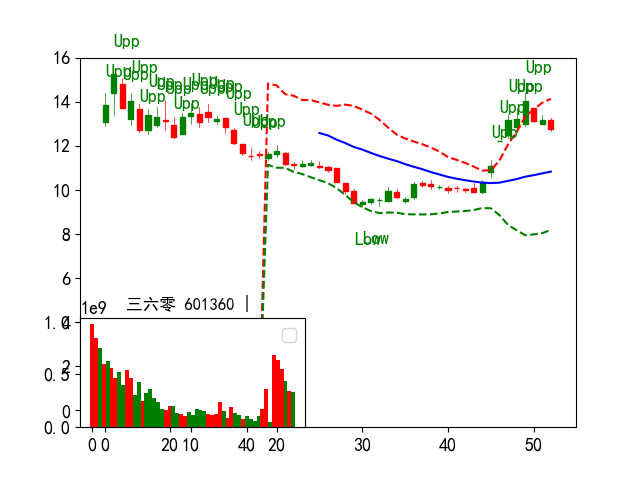

In [113]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'g', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    print("code:",code)
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [114]:
'code' in dfc.columns

True

### show_channel_mpl

In [115]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [116]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None):
    col_src = [
        "name", "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name]
    return temp


def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [117]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.02,
        ma_250_h=1.11, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().market('all').index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    # df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20150501', end=None, freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration(
        h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
        freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)

    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'D'

In [118]:
# resample = 'W-FRI'
resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.02,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 4925
0.7 (4868,) 300253 (308, 6)
resample:D
use time:11.54


In [119]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open  high  low  close          vol        amount
date                                                         
2025-02-13  7.79  8.22  7.7   7.97  574153031.0  4.569428e+09

### Test InStock

In [120]:
df.loc['301083'][:2]

open   high    low  close        vol       amount
date                                                          
2023-11-02  15.78  16.22  15.50   15.5  1845500.0   29343732.0
2023-11-03  15.86  17.83  15.73   16.9  9484947.0  160420160.0

## ra_diff

In [121]:
tail_days = 60

In [122]:
df = df.groupby(level=[0]).tail(tail_days).groupby(level=[0]).apply(ra_diff)


In [123]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(60, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [124]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [125]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [126]:
# df.loc['000002'][-10:]

## sina_dm

In [127]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2025-02-13',
 code
 600220    ST阳光
 Name: name, dtype: object)

In [128]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2025-02/14/25 14:29:04'

code
000062   2025-02-14 14:28:54
301419   2025-02-14 14:28:54
Name: ticktime, dtype: datetime64[ns]

0.17712444067001343

### Combine ratio and idx

In [129]:
# if 'date' in df.columns:
#     print('error duplicated date col')
#     if isinstance(df,pd.MultiIndex):
#         df.drop('date', axis=1, inplace=True)
# else:
#     df = df.reset_index().set_index('code')
#     df['idx'] = df_idx_detect
#     df['xratio'] = df_reg_ratio
#     df['name'] = sina_dm.name
#     df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [130]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df

In [131]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
h5code='603019'
h5.loc[h5code][-3:]
code_muti = '603019'
# h5.loc[code_muti][:2]

freq = 'D'
# freq = '5M'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()
time_ratio
run_col = ['close', 'volume']
# run_col = ['close']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol = round(allvol / 10 / 1000 / 1000,2)
print("总量:%s 亿"%(allvol))
mdf['vol']=mdf['volume'].apply(lambda x: round(x /1000/1000,2)) 
mdf['amount']=(mdf.volume * mdf.close).map(lambda x: round(x/100/1000/1000, 2))
#全局占比
mdf['volume'] = mdf.amount.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
mdf=mdf.reset_index().set_index('code')
mdf.loc[h5code]

['/all_20']
G:\sina_MultiIndex_data.h5


(1584805, 6)

close  high    low  llastp    volume  lastbuy
ticktime                                                          
2025-02-14 14:27:40  73.80  74.5  72.08    72.5  56944029    74.08
2025-02-14 14:28:22  73.76  74.5  72.08    72.5  56985929    73.76
2025-02-14 14:28:55  73.75  74.5  72.08    72.5  57026429    73.75

1.245

总量:18193.11 亿


ticktime    2025-02-15 00:00:00
close                 73.885497
volume                     0.19
vol                       57.03
amount                    42.13
Name: 603019, dtype: object

In [132]:
mdf[:2]
mdf.loc['603019']

ticktime      close  volume     vol  amount
code                                                
000001 2025-02-15  11.485124    0.04   80.89    9.29
000002 2025-02-15   7.784348    0.08  235.62   18.34

ticktime    2025-02-15 00:00:00
close                 73.885497
volume                     0.19
vol                       57.03
amount                    42.13
Name: 603019, dtype: object

In [133]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
str(h5.index.get_level_values(1)[-1])[:10]

'2025-02-14'

In [134]:
if len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2025-02-15 00:00:00
close                  7.784348
volume                     0.08
vol                      235.62
amount                    18.34
Name: 000002, dtype: object

###  实时成交量个股Top!!!

In [135]:
nowdf = mdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
# top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd=get_sina_data_cname(top20_nd)

In [136]:
nowdf.shape,top20_nd

((4855, 5),
           volume  name
 code                  
 399001  22219.77   NaN
 399006   1637.63   NaN
 399005    723.03   NaN
 002261      0.60  拓维信息
 600839      0.54  四川长虹
 300750      0.42  宁德时代
 300251      0.41  光线传媒
 000977      0.40  浪潮信息
 600050      0.38  中国联通
 600126      0.38  杭钢股份
 300059      0.35  东方财富
 000158      0.34  常山北明
 002594      0.34   比亚迪
 000063      0.30  中兴通讯
 301236      0.28  软通动力
 300766      0.27  每日互动
 000938      0.25  紫光股份
 300418      0.24  昆仑万维
 688256      0.24   寒武纪
 600588      0.24  用友网络)

In [137]:
# show_tdx_data(top20_nd)
# top20_nd.columns

### 合并实时成交量及SinaDM

In [138]:
# mdf[:1]
sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
sinadm[:1]

name  open  llastp    now  trade   high   low    buy   sell    volume  \
code                                                                            
601595  上海电影  28.4    29.0  27.35    0.0  28.47  26.8  27.35  27.36  17972265   

        ...            ticktime  b1_vv  close      nvol  lastbuy  nlow  nhigh  \
code    ...                                                                     
601595  ... 2025-02-14 14:28:53   5860  27.35  17972265    27.65  26.8  28.47   

           nclose    vol  amount  
code                              
601595  27.410935  17.97    4.93  

[1 rows x 42 columns]

## check HDF LastDate

In [139]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(0, 7)

(4868, 7)

In [140]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open       high        low      close          vol  \
code   date                                                                  
999999 2025-02-13  3343.2347  3359.1807  3332.4826  3332.4826  568631161.0   

                         amount  ra_diff  
code   date                               
999999 2025-02-13  7.057998e+11     1.05

In [141]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [142]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [143]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [144]:
dfsRoot=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [145]:
# dfs.loc['000002'][-5:].upper
dfsRoot.loc['603357'][-5:][['close','upper','low','boll']][-2:]
dftemp = dfsRoot.loc['603357']
dftemp[dftemp.close > dftemp.upper][:2]
print(dftemp.shape)

close  upper   low  boll
date                                
2025-02-12   9.18   9.12  9.06  8.75
2025-02-13   9.26   9.21  9.26  8.77

open  high   low  close        vol      amount  ra_diff  ma10  \
date                                                                        
2025-02-07  8.90  9.05  8.86   9.00  8868356.0  79738567.0     1.07  8.74   
2025-02-10  9.03  9.05  8.97   9.05  6071808.0  54698833.0     1.07  8.78   

             ma5  ma20  ...  perc2d  perc3d  perc4d  perc5d  vol1d  vol2d  \
date                    ...                                                 
2025-02-07  8.80  8.69  ...    3.09    3.33    3.45    3.93  21.97  79.40   
2025-02-10  8.87  8.72  ...    1.91    3.67    3.90    4.02 -31.53  21.97   

            vol3d  vol4d  vol5d  volsum5d  
date                                       
2025-02-07 -31.21  21.23   0.20      91.6  
2025-02-10  79.40 -31.21  21.23      59.9  

[2 rows x 28 columns]

(60, 28)


In [146]:
# dfs.loc['688027']
dfsRoot['ma51d'] = round(dfsRoot['close'].rolling(5).mean(), 2)
show_tdx_data(dfsRoot.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 29


ra_diff    hat    close  volsum5d     hmax     lmin  perc1d  \
date                                                                      
2025-02-12     1.03  76.13  1443.00     -19.6  1489.79  1400.01    1.76   
2025-02-13     1.04  78.70  1465.06      83.6  1489.79  1400.01    1.53   

               ma20   ma250  vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  \
date                                                                     
2025-02-12  1442.72  367.45   8.07  13.11 -44.04  36.14 -32.88    0.49   
2025-02-13  1443.85  373.26  70.30   8.07  13.11 -44.04  36.14    2.34   

            perc5d    ma51d  ra_diff  
date                                  
2025-02-12    2.79  1428.27     1.03  
2025-02-13    3.70  1438.71     1.04

### Append Now SinaTo MultiIndex dfNow

In [147]:
# tail_days = 60
# cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    if cct.get_work_time_duration():
        sina_today=sina_dm.copy()
        if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
            sina_today['date']=pd.to_datetime(cct.get_today())
            print('concat1 init:sina_today:%s'%(sina_today.index[0]))
            # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
            # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
            # sina_today['idx'] = df_idx_detect2
            # sina_today['xratio'] = df_reg_ratio2
            # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
            if 'vol' in sina_today.columns:
                sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
            else:
                sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat1:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])


    #         sina_today=sina_dm.copy()
    #         #drop line and append idx
    #         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
    #             sina_today['date']=pd.to_datetime(cct.get_today())
    #             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

    #             sina_today['idx'] = df_idx_detect2
    #             sina_today['xratio'] = df_reg_ratio2
    #             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
    #             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


    #         df = get_multiIndex_drop_last_row(df,dropline=1)

            if sina_today.index[0] not in df.index:
                # df.index=df.index.append(sina_dm.index)
                print('concat2:sina_today:%s %s'%(sina_today.index[0]))
                df = pd.concat([df, sina_today])
            df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfsRoot=get_Append_Sina_To_MultiTDX(dfsRoot.groupby(level=[0]).tail(tail_days),sinadm)
    dfNow= dfsRoot.groupby(level=[0]).tail(tail_days/2)
    
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfsRoot.groupby(level=[0]).tail(tail_days/2).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df[-2:]
dfNow[-2:]

concat1 init:sina_today:601595
concat1:sina_today:601595 2025-02-14 00:00:00


open   high    low  close           vol        amount  \
code   date                                                                 
000001 2025-02-13  11.42  11.55  11.40  11.50  1.358639e+08  1.560710e+09   
       2025-02-14  11.49  11.54  11.43  11.52  8.089000e+01  9.290000e+00   

                   ra_diff   ma10    ma5   ma20  ...  perc4d  perc5d  vol1d  \
code   date                                      ...                          
000001 2025-02-13     1.04  11.40  11.43  11.38  ...    1.05    1.23   37.4   
       2025-02-14      NaN  11.42  11.46  11.39  ...    0.79    1.23 -100.0   

                   vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  name  
code   date                                                           
000001 2025-02-13  17.09 -17.74 -27.06  47.29      57.0  11.43   NaN  
       2025-02-14  37.40  17.09 -17.74 -27.06     -90.3    NaN  平安银行  

[2 rows x 30 columns]

In [148]:
dfsRoot.groupby(level=[0]).tail(60).loc['000002'][-1:]


open  high   low  close     vol  amount  ra_diff  ma10  ma5  ma20  \
date                                                                            
2025-02-14  7.93  8.05  7.71   7.78  235.62   18.34      NaN   NaN  NaN   NaN   

            ...  perc4d  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  \
date        ...                                                                
2025-02-14  ...     NaN     NaN    NaN    NaN    NaN    NaN    NaN       NaN   

            ma51d  name  
date                     
2025-02-14    NaN  万 科Ａ  

[1 rows x 30 columns]

### Xratio and tail 60 MultiIndex 

In [149]:
## dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
if 'xratio' not in dfNow.columns:
    df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
    df_xratio.index =df_xratio.to_frame().index.droplevel(1)
    dfNow['xratio'] = df_xratio

In [150]:
# df_xratio.loc['605589'][-8:]
dfsRoot.loc['603019'][:1]
# dfNow[-12:][-2:]

open   high    low  close          vol        amount  ra_diff  \
date                                                                         
2024-11-13  81.91  85.59  81.58   82.7  110898616.0  9.246765e+09     1.36   

             ma10    ma5   ma20  ...  perc4d  perc5d    vol1d  vol2d  vol3d  \
date                             ...                                          
2024-11-13  15.73  23.28  11.73  ...  893.99  908.54  1146.66  23.78 -51.87   

             vol4d  vol5d  volsum5d  ma51d  name  
date                                              
2024-11-13  211.34 -31.16    1298.8  23.28   NaN  

[1 rows x 30 columns]

## DFNow Query check

In [151]:
dfNow_A = dfNow.query('@dfNow.index.get_level_values(0) < "688000"')
# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')
# dfNow.groupby(level=[0]).tail(3)
lastworkday = cct.last_tddate(1)
print(lastworkday)
# dfxra.groupby(level=[0]).tail(1).query('date >= @lastworkday').xratio
# dfxra.query('@dfxra.index.get_level_values(0) < "688000"')
# dfxra.query('not @dfxra.index.get_level_values(0).str.contains("688") ')

# df.query(f'ColumnName >= {VariableName}')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('0 > xratio > -0.08 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

# dfxra = dfNow_A.groupby(level=[0]).tail(3).query('xratio > 0 and xratio.shift(1) < 0 and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))*1.1')

dfxra = dfNow_A.groupby(level=[0]).tail(3).query('high > upper  and xratio - xratio.shift(1) > (xratio.shift(1) - xratio.shift(2))')

dfxra.query('date >= @lastworkday').sort_values(by='xratio',ascending=0).xratio[:10]
# dfxra.query('date >= @lastworkday').xratio[:10]

# dfxra.query('date >= @lastworkday').loc['605589'].xratio
df_xratio.loc['605369'][-8:]

2025-02-13


code    date      
603666  2025-02-13    0.48
603290  2025-02-13    0.42
603881  2025-02-13    0.42
300688  2025-02-13    0.41
301378  2025-02-13    0.32
300895  2025-02-13    0.30
300377  2025-02-13    0.29
300687  2025-02-13    0.29
002869  2025-02-13    0.25
603721  2025-02-13    0.25
Name: xratio, dtype: float64

date
2025-02-05     NaN
2025-02-06    0.05
2025-02-07    0.06
2025-02-10    0.08
2025-02-11    0.09
2025-02-12    0.10
2025-02-13    0.10
2025-02-14    0.09
Name: close, dtype: float64

In [152]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2025-02-13    6.74
2025-02-14     NaN
Name: upper, dtype: float64

(60, 30)
xratio:-0.01 ra_diff:nan
code: 300459


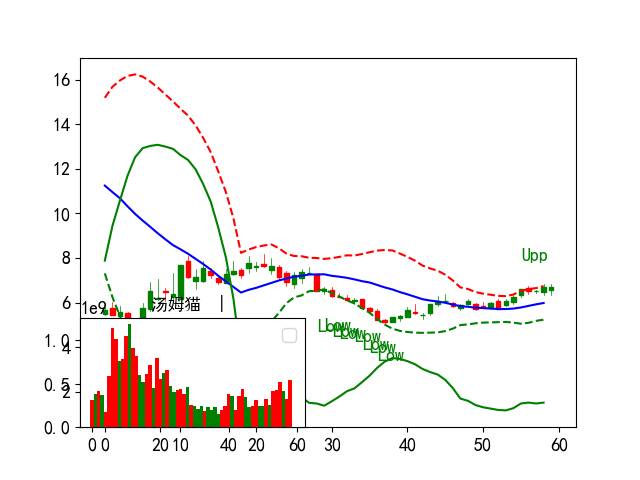

In [153]:
dfNow.loc['300459'][-2:].upper
print(dfsRoot.loc['300459'][-tail_days:].shape)
show_ohlc_upper(dfsRoot.loc['300459'][-tail_days:],code='300459')

399001 date
2025-02-12    1.09
2025-02-13    1.08
Name: ra_diff, dtype: float64
xratio:-10.42 ra_diff:1.08
code: 399001


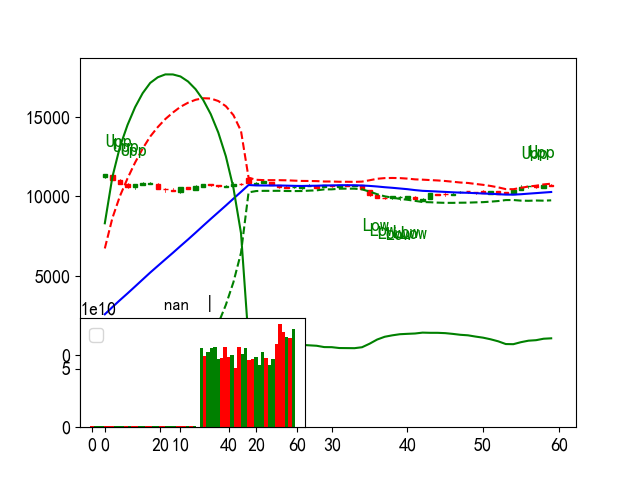

399006 date
2025-02-12    1.11
2025-02-13    1.10
Name: ra_diff, dtype: float64
xratio:-3.21 ra_diff:1.1
code: 399006


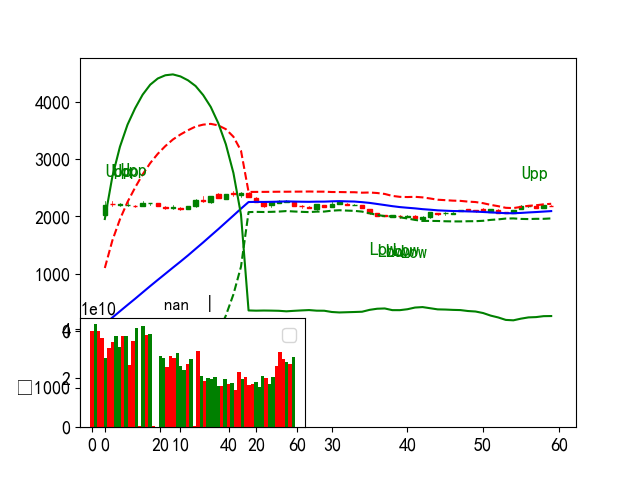

In [154]:
for co in top20_nd.index[:2]:
    print(co,dfNow.loc[co].ra_diff[-2:])
    # show_ohlc_upper(dfs.loc[co][-30:],co)
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],co)

In [155]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date   open   high    low  close    vol  amount  ra_diff   ma10  \
code                                                                           
689009 2025-02-14  52.39  55.65  52.13  54.55  12.89    7.05      NaN  46.98   
688793 2025-02-14  28.04  28.78  27.82  28.51   0.87    0.25      NaN  27.69   

          ma5  ...  vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  name  \
code           ...                                                             
689009  47.12  ... -100.0  -0.36  -0.37 -30.97  28.06    -103.6    NaN  九号公司   
688793  28.65  ... -100.0 -13.88 -57.34  11.27  99.82     -60.1    NaN   倍轻松   

        xratio   idx  
code                  
689009    0.18  6.76  
688793   -0.04  1.93  

[2 rows x 33 columns]

In [156]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [157]:
df.loc['000002'][-2:]

open  high   low  close          vol        amount  ra_diff
date                                                                   
2025-02-12  7.25  7.96  7.13   7.96  379738987.0  2.862875e+09      1.2
2025-02-13  7.79  8.22  7.70   7.97  574153031.0  4.569428e+09      1.2

In [158]:
dfNow.loc['000002'][-2:]

open  high   low  close           vol        amount  ra_diff  \
date                                                                       
2025-02-13  7.79  8.22  7.70   7.97  5.741530e+08  4.569428e+09      1.2   
2025-02-14  7.93  8.05  7.71   7.78  2.356200e+02  1.834000e+01      NaN   

            ma10   ma5  ma20  ...  vol1d   vol2d   vol3d  vol4d  vol5d  \
date                          ...                                        
2025-02-13  7.40  7.60  7.15  ...   51.2  118.73   -6.77 -43.04  74.94   
2025-02-14  7.44  7.67  7.19  ... -100.0   51.20  118.73  -6.77 -43.04   

            volsum5d  ma51d  name  xratio   idx  
date                                             
2025-02-13     195.1    7.6   NaN    0.03  0.61  
2025-02-14      20.1    NaN  万 科Ａ    0.04  0.39  

[2 rows x 32 columns]

# 基础处理

In [159]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2025-01-13 2025-02-13


open   high    low  close           vol        amount  \
code   date                                                                 
000001 2025-02-13  11.42  11.55  11.40  11.50  1.358639e+08  1.560710e+09   
       2025-02-14  11.49  11.54  11.43  11.52  8.089000e+01  9.290000e+00   

                   ra_diff   ma10    ma5   ma20  ...  vol1d  vol2d  vol3d  \
code   date                                      ...                        
000001 2025-02-13     1.04  11.40  11.43  11.38  ...   37.4  17.09 -17.74   
       2025-02-14     0.00  11.42  11.46  11.39  ... -100.0  37.40  17.09   

                   vol4d  vol5d  volsum5d  ma51d  name  xratio   idx  
code   date                                                           
000001 2025-02-13 -27.06  47.29      57.0  11.43     0    -0.0  0.18  
       2025-02-14 -17.74 -27.06     -90.3   0.00  平安银行     0.0  0.18  

[2 rows x 32 columns]

Low:2025-01-13


Timestamp('2025-01-13 00:00:00')

In [160]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
        top_temp = top_temp[(~top_temp.index.str.contains(
            '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(12977, 32)
count dd.couts
(code    date      
301080  2025-01-13    17
688419  2025-01-14    17
688386  2025-01-14    17
688290  2025-01-14    17
688160  2025-01-14    17
Name: couts, dtype: int64, (12977, 33))
dt_low:2025-01-13 df:995 Index(['688419', '688386', '688290', '688160', '688152'], dtype='object', name='code') df_idx:2385
Main Down dd :0 MainUP df:995 couts std:3.8 
time: 0.06  939


In [161]:
dfs_dtlen.loc['002987'][-1:]

open   high    low  close    vol  amount  ra_diff  ma10    ma5  \
date                                                                          
2025-02-14  16.72  18.37  16.48  17.64  53.81    9.58      0.0  15.7  16.78   

             ma20  ...  vol1d  vol2d  vol3d  vol4d  vol5d  volsum5d  ma51d  \
date               ...                                                       
2025-02-14  14.69  ... -100.0  26.12 -30.99  16.89  97.28       9.3    0.0   

            name  xratio   idx  
date                            
2025-02-14   京北方    0.17  3.35  

[1 rows x 32 columns]

## 最近60天筛选

In [162]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(tail_days)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [163]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(
    df_mask250)[:3]

(1364, 32)
count dd.couts
(code    date      
605155  2024-12-26    21
Name: couts, dtype: int64, (1364, 33))
(code    date      
605155  2025-02-12    21
688192  2025-02-10    14
Name: couts, dtype: int64, (351, 33))
Count:351 33


name  couts  ra_diff  xratio   idx   hat  close  \
code   date                                                         
600889 2025-02-12    0      3     3.04    0.13  2.02  3.74  20.12   
002347 2025-02-06    0      2     1.65    0.03  0.00  1.52   7.57   
600228 2024-12-26    0      1     1.60    0.00  0.00  2.00   7.29   

                      volsum5d   hmax   lmin  perc1d   ma20  ma250  \
code   date                                                          
600889 2025-02-12         98.8  20.82  15.90    1.67  18.60  19.01   
002347 2025-02-06        -16.7   7.80   6.07    5.29   6.99   6.90   
600228 2024-12-26  147582493.0   9.17   6.72   -5.81   6.96   6.64   

                          vol1d   vol2d  vol3d  vol4d  vol5d  perc3d  perc5d  
code   date                                                                   
600889 2025-02-12  1.470000e+00    7.49 -40.08  58.61  71.31    1.36   13.48  
002347 2025-02-06  6.485000e+01    9.24 -35.07 -29.25 -26.46    3.27    1.88  
600228 2024-12-26  1.475826e+08 -100.00 -11.84 -10.79   6.96   -0.95    0.83

#### filter today

In [164]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [165]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [166]:
dfs.loc['301073'][-5:].ra_diff

date
2025-02-10    1.14
2025-02-11    1.13
2025-02-12    1.14
2025-02-13    1.13
2025-02-14    0.00
Name: ra_diff, dtype: float64

xratio:-0.03 ra_diff:nan
code: 000002


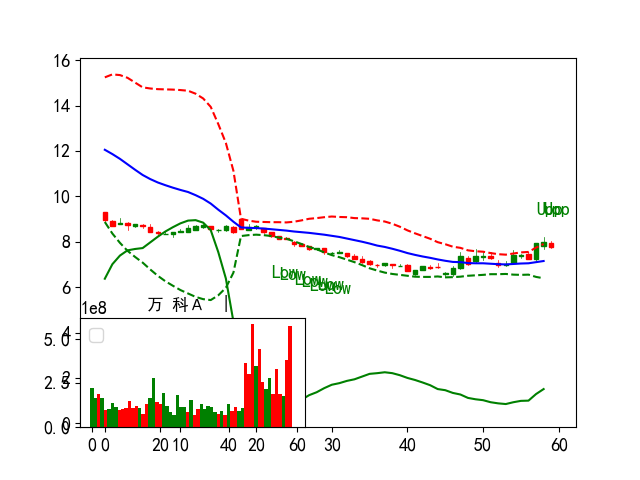

In [167]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfsRoot.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-tail_days:],code=co)

## 最近60天数据

In [168]:
dfs_tail9 = dfs.groupby(level=[0]).tail(tail_days)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [169]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2025-02-11    1.05
        2025-02-12    1.06
        2025-02-13    1.05
399001  2025-02-11    1.08
        2025-02-12    1.09
        2025-02-13    1.08
399006  2025-02-11    1.09
        2025-02-12    1.11
        2025-02-13    1.10
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [170]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])[-2:]
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:30 32


name  ra_diff  xratio   idx   hat  close  volsum5d   hmax   lmin  \
date                                                                           
2025-02-13     0     1.13     0.1  1.03  3.04  18.57      -9.8  19.15  15.75   
2025-02-14  上海沪工     0.00     0.1  0.80  0.00  18.53    -151.0   0.00   0.00   

            perc1d   ma20  ma250   vol1d  vol2d  vol3d  vol4d  vol5d  perc3d  \
date                                                                           
2025-02-13   -1.90  17.76  12.13    5.25   4.68 -29.67 -31.26  41.17   -2.26   
2025-02-14   -0.22  17.84   0.00 -100.00   5.25   4.68 -29.67 -31.26   -1.12   

            perc5d  
date                
2025-02-13    1.31  
2025-02-14   -1.33

## !!! Run-Filter强势Upper

### !!! filterRule test

In [171]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



30
9 0.11 1.0


'Bull'

1.0

date
2025-02-10   -0.00
2025-02-11    0.01
2025-02-12    0.02
2025-02-13    0.03
2025-02-14    0.03
Name: xratio, dtype: float64

xratio:0.01 ra_diff:nan
code: 601728


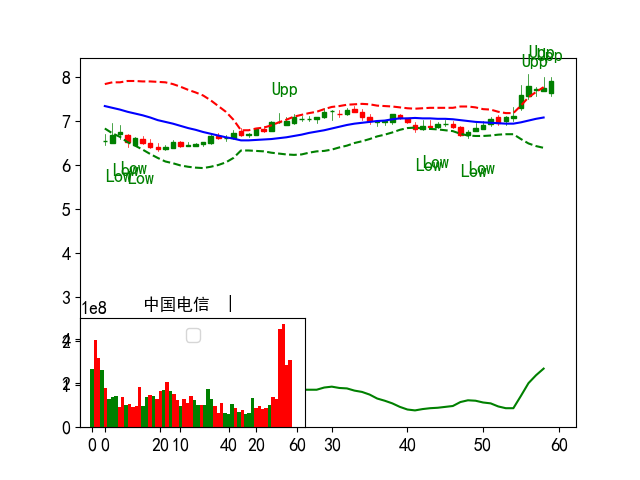

In [172]:
code_filter = '601728'

print(len(dfs_tail9.loc[code_filter]))

# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfsRoot.loc[code_filter][-60:], code=code_filter)



In [173]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高 TEST

30
xratio:0.03 ra_diff:nan
code: 600012


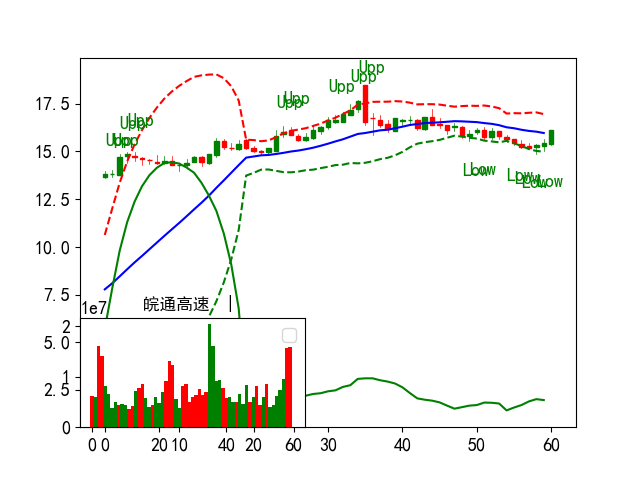

In [174]:
code='600012'
print(len(dfs_tail9.loc[code]))
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfsRoot.loc[code],code=code)

In [175]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)[:10]
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 601166    14
 Name: couts, dtype: int64,
 (808, 41))

Count:808 41


name  couts       date   perc  ra_diff  xratio    idx    hat   close  \
code                                                                           
601166  兴业银行     14 2025-02-14   1.98     0.00    0.06   0.90   0.00   21.13   
002881  美格智能     12 2025-02-13  -7.13     2.70    1.61  31.24  54.38   59.89   
600580  卧龙电驱     12 2025-02-13  -3.19     1.84    0.51   5.76  14.41   24.57   
601177  杭齿前进     11 2025-02-14   9.98     0.00    0.13   3.17   0.00   12.34   
603881   数据港     10 2025-02-14  10.00     0.00    0.52  13.57   0.00   34.10   
603501  韦尔股份     10 2025-02-13  -1.14     1.41    1.29  29.69  43.04  134.50   
300681   英搏尔     10 2025-02-13  -3.09     1.61    0.53   8.55  14.79   34.82   
002648  卫星化学     10 2025-02-13  -0.14     1.20    0.08   1.38   2.43   20.85   
002896  中大力德     10 2025-02-13  -0.61     2.14    1.56  14.94  43.29   63.83   
301061  匠心家居     10 2025-02-13   1.14     1.49    1.02   5.08  23.08   80.18   

        volsum5d  ...  ma250      nclose    llow   vol1d    vol2d  vol3d  \
code              ...                                                      
601166     -89.3  ...   0.00   20.992613   20.66 -100.00   -37.06  67.03   
002881    2079.0  ...  19.18   61.248822   64.16   24.50  1593.96  59.42   
600580      24.3  ...   9.37   24.871551   25.18   50.11   -13.24 -20.08   
601177    -113.9  ...   0.00   12.340000   11.98 -100.00   -23.67 -12.30   
603881     779.1  ...   0.00   34.100000   31.00 -100.00   929.89 -92.22   
603501     111.8  ...  40.01  135.067627  135.59   24.43    30.48  27.59   
300681      61.5  ...  21.81   35.200863   35.59   42.94    29.00 -12.12   
002648      16.5  ...  10.43   20.840482   20.84   -7.61   -52.74  96.26   
002896     -29.2  ...  28.30   64.479265   63.23   -3.53   -25.54  41.06   
301061     -44.1  ...  27.53   80.231636   79.00  -10.97   -18.49  32.57   

         vol4d  vol5d  perc3d  perc5d  
code                                   
601166  -43.63  24.39    3.83    5.02  
002881  339.48  61.68    9.45   32.45  
600580   33.02 -25.50   -6.38    5.18  
601177   61.58 -39.55   33.12   34.28  
603881   25.42  16.06   33.10   51.89  
603501  -44.47  73.80   14.97   19.82  
300681  -16.43  18.14    9.68   15.60  
002648  -11.49  -7.95    3.93    4.82  
002896  -33.89  -7.32    1.90   -0.96  
301061  -35.91 -11.28   -2.47    2.30  

[10 rows x 24 columns]

#### !!! hmax Top upper > 1

In [176]:
# dfs_tail9.loc['600103']

In [177]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['volsum5d', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape

# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])

show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1)] )[:10]

count dd.couts
compute percent
code
002929    7
Name: couts, dtype: int64 (451, 41)


(code
 002929    7
 Name: couts, dtype: int64,
 (451, 41))

Count:363 41


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                           
002929   润建股份      7 2025-02-14  10.00     0.00    0.81  21.63   0.00  55.22   
600387  *ST海越      5 2025-02-14  -1.85     0.00    0.02   0.57   0.00   3.18   
600633   浙数文化      7 2025-02-13   9.88     1.85    0.31   7.13  11.52  18.46   
002016   世荣兆业      5 2025-02-13  -9.16     1.48    0.07   2.58   3.27   7.34   
600126   杭钢股份     10 2025-02-14   9.97     0.00    0.22   6.22   0.00  11.14   
600081   东风科技      4 2025-02-14   0.86     0.00    0.15   3.93   0.00  14.09   
000818   航锦科技      7 2025-02-14   5.29     0.00    0.59  16.59   0.00  31.85   
002123   梦网科技      7 2025-02-14  10.01     0.00    0.35  11.79   0.00  22.86   
605398   新炬网络     10 2025-02-13 -10.00     2.96    1.33  29.63  44.75  47.43   
603881    数据港      9 2025-02-14  10.00     0.00    0.52  13.57   0.00  34.10   

        volsum5d  ...  ma250     nclose   llow    vol1d    vol2d   vol3d  \
code              ...                                                      
002929    2826.1  ...   0.00  54.368631  45.58  -100.00  2814.03  -89.67   
600387    2027.5  ...   0.00   3.190074   3.14  -100.00  2170.72   61.91   
600633    2011.9  ...   8.08  17.315399  16.29  2067.21    77.11   -1.67   
002016    1365.6  ...  10.04   7.418521   7.66    35.01  1279.39  -70.45   
600126    1261.5  ...   0.00  10.866592   9.23  -100.00  1424.61  -18.96   
600081     890.9  ...   0.00  14.364618  13.45  -100.00    -3.31    1.72   
000818     875.8  ...   0.00  31.852115  29.26  -100.00   -72.26  112.01   
002123     871.8  ...   0.00  22.860000  22.30  -100.00  1060.80  -88.87   
605398     814.7  ...  70.51  47.430000  45.95   423.83   200.46  337.81   
603881     779.1  ...   0.00  34.100000  31.00  -100.00   929.89  -92.22   

          vol4d  vol5d  perc3d  perc5d  
code                                    
002929   261.21 -59.50   28.66   55.68  
600387   -17.97 -87.20    8.16   19.10  
600633   -61.63 -69.11   12.37   36.03  
002016    67.77  53.91   18.48   43.26  
600126    -4.35 -39.75   33.09   60.98  
600081  1065.21 -72.77    7.72   30.34  
000818  1030.08 -93.99   17.74   42.51  
002123   -40.19  40.08   33.14   61.10  
605398   -54.52 -92.84   28.91   56.01  
603881    25.42  16.06   33.10   51.89  

[10 rows x 24 columns]

In [178]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [179]:
show_tdx_data(
    df_mask_hmax.sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')[:20]

Count:451 41


name  couts       date   perc  ra_diff  ra_diff  xratio    idx    hat  \
code                                                                            
605398  新炬网络     10 2025-02-13 -10.00     2.96     2.96    1.33  29.63  44.75   
002691  冀凯股份      9 2025-02-13  -9.97     2.95     2.95    0.38   5.31  10.68   
002364  中恒电气      7 2025-02-13  -5.08     2.47     2.47    0.07   4.47   5.42   
002031  巨轮智能      5 2025-02-13 -10.02     2.46     2.46    0.16   2.73   4.06   
000681  视觉中国      3 2025-02-13  -8.80     2.26     2.26    0.34  10.58  11.80   
600120  浙江东方      7 2025-02-13  -9.44     2.06     2.06    0.18   4.17   6.52   
600633  浙数文化      7 2025-02-13   9.88     1.85     1.85    0.31   7.13  11.52   
603300  海南华铁      6 2025-02-13  -3.58     1.83     1.83    0.12   3.80   4.96   
603366  日出东方      2 2025-02-13  -8.00     1.80     1.80    0.04   3.53   4.44   
002878  元隆雅图      2 2025-02-13  -7.32     1.73     1.73    0.19   4.49   5.30   
603666   亿嘉和      3 2025-02-13   0.22     1.67     1.67    0.48   8.49  12.76   
300681   英搏尔      8 2025-02-13  -3.09     1.61     1.61    0.53   8.55  14.79   
300806   斯迪克      7 2025-02-13  -2.90     1.61     1.61    0.31   4.18   9.04   
301160  翔楼新材      4 2025-02-13  -5.29     1.60     1.60    0.97  13.52  29.80   
300674  宇信科技      2 2025-02-13  -3.73     1.58     1.58    0.29   8.24  10.84   
300571  平治信息      5 2025-02-13  -1.52     1.55     1.55    0.46  10.69  16.27   
000158  常山北明      5 2025-02-13  -1.32     1.53     1.53    0.29   8.86  11.37   
603950  长源东谷      4 2025-02-13   2.79     1.51     1.51    0.18   2.11   5.33   
002575  群兴玩具      2 2025-02-13  -4.13     1.51     1.51    0.03   2.43   2.50   
600173  卧龙地产      6 2025-02-13  -5.49     1.50     1.50    0.05   1.43   1.80   

        close  ...  ma250     nclose   llow    vol1d   vol2d   vol3d   vol4d  \
code           ...                                                             
605398  47.43  ...  70.51  47.430000  45.95   423.83  200.46  337.81  -54.52   
002691  12.37  ...   8.92  12.511561  12.02    59.50  -30.78   -1.98  -11.07   
002364  16.62  ...   8.35  16.699460  15.71   348.71  -73.97   49.75   10.07   
002031   8.44  ...  20.20   8.440000   8.54    -8.21   81.81  -21.01  -16.52   
000681  27.88  ...  11.36  28.300450  29.07    49.27   19.08  -25.18  -21.38   
600120   7.87  ...   6.01   7.924071   8.13   184.08  -34.09  -39.72    5.72   
600633  18.46  ...   8.08  17.315399  16.29  2067.21   77.11   -1.67  -61.63   
603300   8.63  ...  14.67   8.581897   7.76    -9.85   96.41  675.26  -30.96   
603366  13.22  ...  21.89  13.394135  14.00    -1.73   23.56   73.86   31.04   
002878  19.24  ...  22.69  19.376392  20.00   -25.80   58.81   51.42   -9.90   
603666  35.88  ...  18.16  36.204742  34.71   399.11  -66.15  105.16  -44.17   
300681  34.82  ...  21.81  35.200863  35.59    42.94   29.00  -12.12  -16.43   
300806  19.11  ...  25.84  19.146131  19.00    -6.56   31.10  -31.60  -14.50   
301160  74.59  ...  37.91  76.668185  72.22    40.30  -27.67    4.13   41.40   
300674  26.61  ...  27.27  27.000032  24.08   206.09  -25.57  -22.72   71.45   
300571  34.37  ...  33.03  34.406667  32.38    17.73  -10.91   14.45   55.88   
000158  26.90  ...  13.41  27.333089  25.81    36.49  -15.87   28.12    8.58   
603950  21.75  ...  14.02  21.472926  20.92    14.41  127.04  -12.66   -5.99   
002575   8.36  ...  10.87   8.450096   8.12    49.14   -1.09  -31.51  104.88   
600173   5.34  ...   8.72   5.369381   5.22   139.37   28.18   40.50  -29.58   

         vol5d  perc3d  perc5d  
code                            
605398  -92.84   28.91   56.01  
002691  141.73   33.14   35.91  
002364   17.70   29.99   44.59  
002031    5.51   24.07   31.74  
000681    5.83   15.31   19.41  
600120  382.14   16.49   41.07  
600633  -69.11   12.37   36.03  
603300  -55.28   23.62   49.67  
603366   48.42   21.88   30.99  
002878  -16.54   17.82   13.44  
603666   -2.43   22.73   17.26  
300681   18.14    9.68   15.60  
30

xratio:-0.01 ra_diff:nan
code: 300540


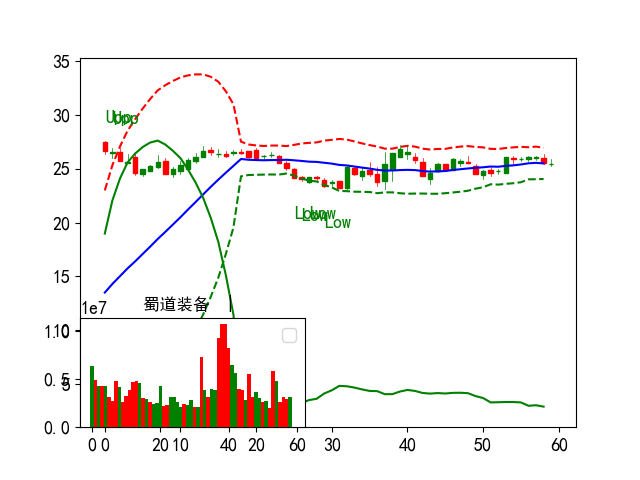

In [180]:
show_ohlc_upper(dfsRoot.loc['300540'][-60:],code='300540')

### !!! df_mask250 upper xratio

In [181]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))

show_tdx_data(df_mask250[df_mask250.couts > 1][:20])
# show_tdx_data(df_mask250.loc[code_t])

(2484, 32)

count dd.couts
(code    date      
688685  2025-02-07    6
688244  2025-02-07    6
600588  2025-02-07    6
Name: couts, dtype: int64, (1925, 33))
compute percent
df_mask250:1181 df_mask_hmax:451
cross_hamx:345
Count:20 41


name  couts       date   perc  ra_diff  xratio     idx     hat  \
code                                                                     
399001     0      2 2025-02-10    NaN     1.09   13.65  374.85  899.79   
999999     0      3 2025-02-12    NaN     1.06    4.38  132.76  187.72   
300454   深信服      4 2025-02-14  20.00     0.00    1.65   46.31    0.00   
002594   比亚迪      3 2025-02-11   4.37     1.24    2.03   43.85   84.32   
002881  美格智能      4 2025-02-12  -7.13     2.99    1.43   37.85   50.81   
300766  每日互动      4 2025-02-12  -3.28     3.95    1.39   37.12   52.22   
301220  亚香股份      3 2025-02-12  -4.95     2.44    1.03   37.06   46.04   
603444   吉比特      2 2025-02-14   3.66     0.00    1.25   36.25    0.00   
603501  韦尔股份      5 2025-02-13  -1.14     1.41    1.29   29.69   43.04   
300760  迈瑞医疗      2 2025-02-14   4.40     0.00    0.58   28.00    0.00   
300251  光线传媒      6 2025-02-14  20.01     0.00    0.78   25.23    0.00   
002850   科达利      2 2025-02-11   0.28     1.50    1.62   25.07   51.22   
002929  润建股份      4 2025-02-14  10.00     0.00    0.81   21.63    0.00   
301236  软通动力      2 2025-02-10   3.04     1.47    0.49   20.32   26.41   
603297  永新光学      2 2025-02-10   0.70     1.39    0.51   19.46   26.46   
000034  神州数码      4 2025-02-14   9.99     0.00    0.73   19.36    0.00   
300779  惠城环保      3 2025-02-14   0.18     0.00    0.43   19.08    0.00   
300676  华大基因      2 2025-02-14  13.00     0.00    0.63   18.68    0.00   
300378  鼎捷数智      2 2025-02-12   3.49     1.91    0.80   18.42   26.65   
300496  中科创达      2 2025-02-10   0.73     1.40    0.41   17.94   27.25   

             close  volsum5d  ...    ma250      nclose        llow    vol1d  \
code                          ...                                             
399001  10631.2460      38.5  ...  2912.58         NaN  10532.1190    -7.98   
999999   3346.3854      28.7  ...     0.00         NaN   3310.3904     0.29   
300454    105.5900     -57.9  ...     0.00  102.884800     87.5000  -100.00   
002594    356.2200     278.2  ...    84.06  354.789143    326.0100     2.81   
002881     59.8900    2006.2  ...    18.98   61.248822     67.0000  1593.96   
300766     53.8900    2005.2  ...    22.86   55.673301     49.5300   -12.29   
301220     68.1000     142.8  ...    32.25   69.601558     66.1000    81.27   
603444    243.1700    -108.7  ...     0.00  236.377915    227.8800  -100.00   
603501    134.5000     111.8  ...    40.01  135.067627    135.5900    24.43   
300760    262.0400    -194.6  ...     0.00  259.664792    250.1800  -100.00   
300251     34.7300    -105.4  ...     0.00   34.720935     32.0000  -100.00   
002850    127.5100     138.8  ...    42.86  128.214968    128.0000   -22.77   
002929     55.2200    2826.1  ...     0.00   54.368631     45.5800  -100.00   
301236     70.5400     261.7  ...    35.80   70.908814     73.9000     0.30   
603297    105.4300     141.9  ...    30.69  105.657200    105.5300    -8.10   
000034     52.9400     -19.7  ...     0.00   52.940000     46.2800  -100.00   
300779    105.2800       8.4  ...     0.00  108.640297    102.5600  -100.00   
300676     57.6300    -178.4  ...     0.00   56.565513     51.4800  -100.00   
300378     43.0100     -12.7  ...    26.16   43.701447     41.1200   -23.32   
300496     66.2800     -10.6  ...    24.69   66.534759     68.0700   -40.62   

          vol2d   vol3d   vol4d    vol5d  perc3d  perc5d  
code                                                      
399001    24.78   21.90    9.46    -9.68    4.59    3.29  
999999    -6.34   -8.99   30.32    13.40    1.29    3.62  
300454    35.71   38.60  -37.31     5.10   39.06   45.36  
002594   -44.01   27.69  162.44   129.23    6.05   20.18  
002881    59.42  339.48   61.68   -48.34   33.10   61.07  
300766    41.58  -32.84  138.72  1869.99   37.71   90.18  
301220    -2.31   46.30  -30.89    48.48   67.87   54.55  
603444     6.79   17.94  -19.92   -13.48    6.30    8.38  
603501    30.48   27.59  -44.47    73.80   14.97  

df_mask250:322
399001 1.08
xratio:-10.42 ra_diff:1.08
code: 399001


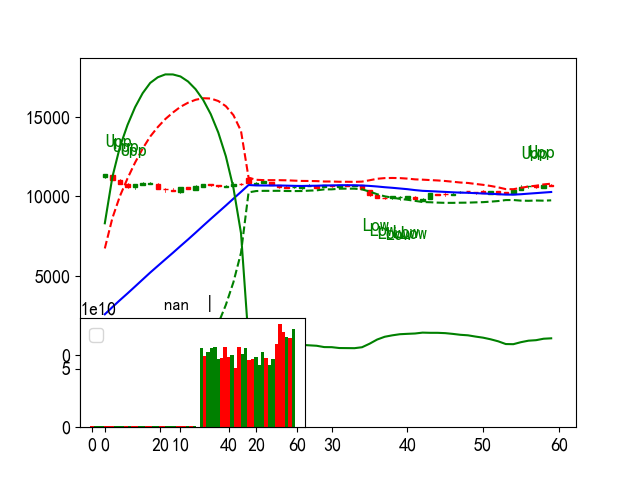

999999 1.05
xratio:-2.2 ra_diff:1.05
code: 999999


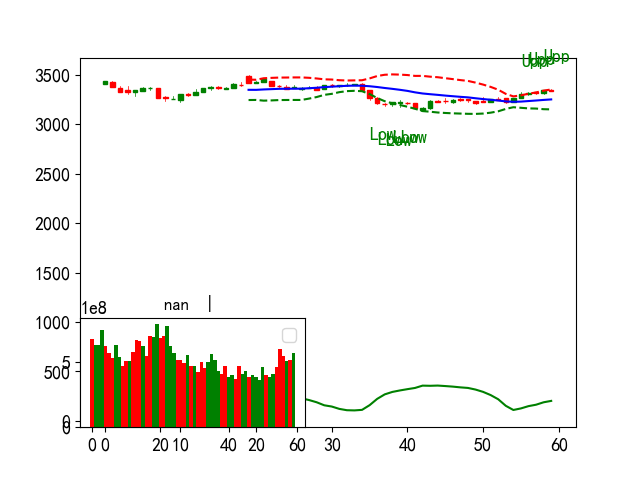

300454 0.0
xratio:0.03 ra_diff:nan
code: 300454


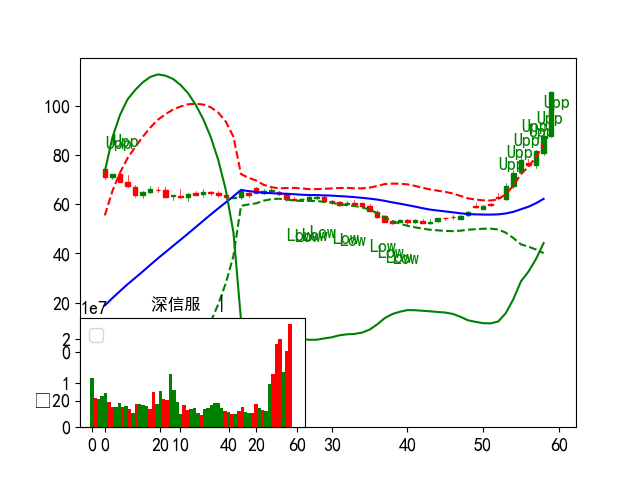

002594 0.0
xratio:0.44 ra_diff:nan
code: 002594


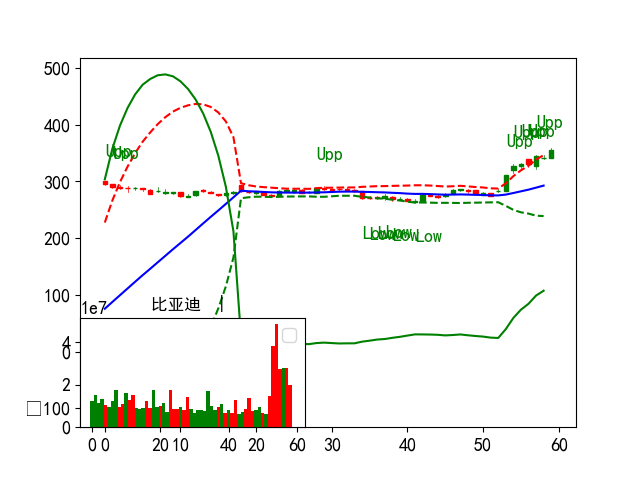

002881 0.0
xratio:0.48 ra_diff:nan
code: 002881


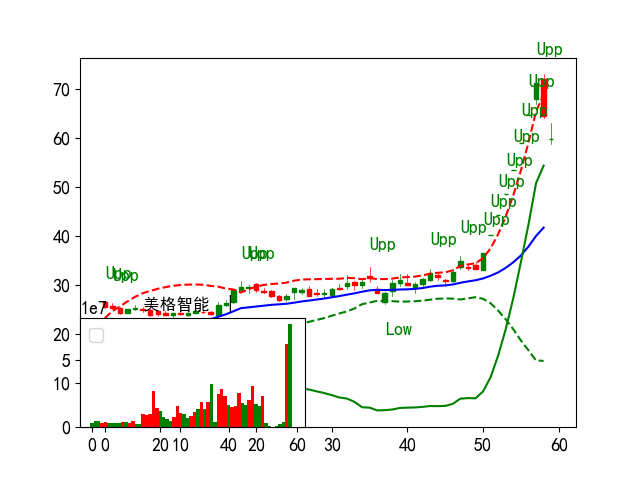

300766 0.0
xratio:0.4 ra_diff:nan
code: 300766


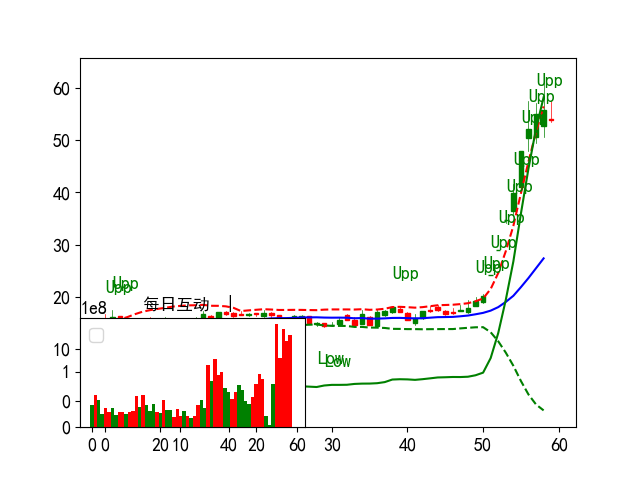

301220 0.0
xratio:0.36 ra_diff:nan
code: 301220


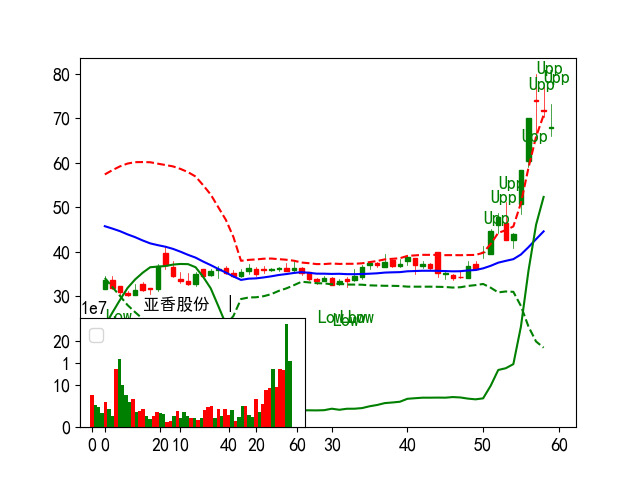

603444 0.0
xratio:0.24 ra_diff:nan
code: 603444


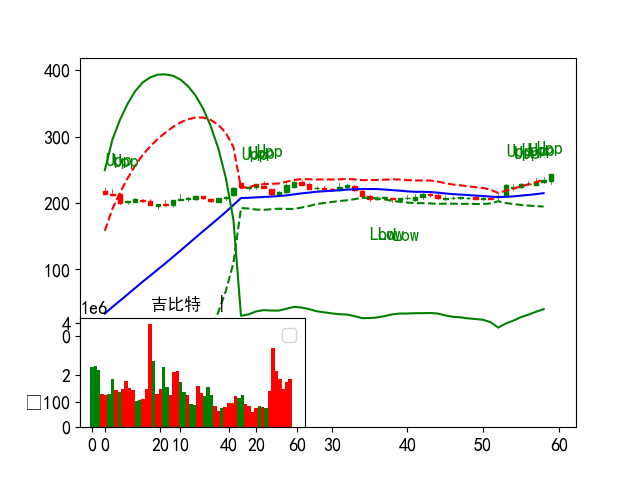

603501 0.0
xratio:0.3 ra_diff:nan
code: 603501


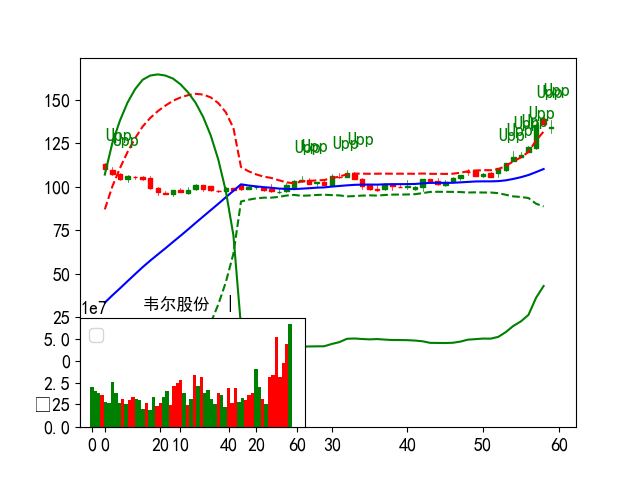

300760 0.0
xratio:-0.62 ra_diff:nan
code: 300760


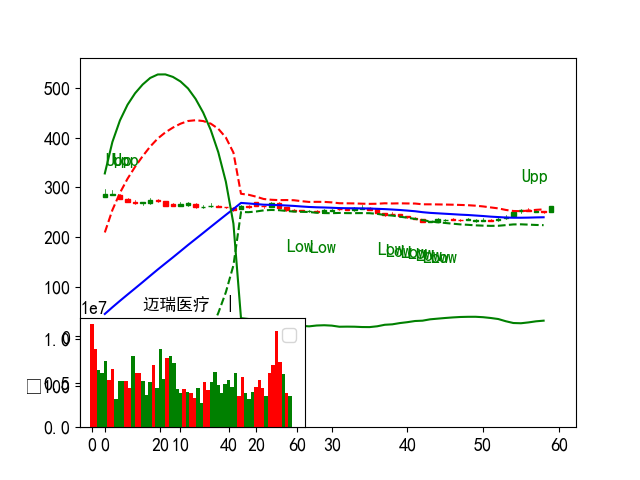

In [182]:
print("df_mask250:%s"%(len(df_mask250[df_mask250.couts > 1])))
for co in df_mask250[df_mask250.couts > 1].index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [183]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date       lopen       lhigh        llow       close  \
code                                                                
399001 2025-02-10  10608.6060  10645.9610  10532.1190  10631.2460   
999999 2025-02-12   3312.2572   3346.3854   3310.3904   3346.3854   

                 vol        amount  ra_diff      ma10       ma5  ...  xratio  \
code                                                             ...           
399001  8.164280e+10  1.053786e+12     1.09  10317.80  10384.23  ...   13.65   
999999  5.134378e+08  6.473876e+11     1.06   3273.74   3312.19  ...    4.38   

           idx  couts  nclose  open  high  low  llastp  ticktime  perc  
code                                                                    
399001  374.85      2     NaN   NaN   NaN  NaN     NaN       NaT   NaN  
999999  132.76      3     NaN   NaN   NaN  NaN     NaN       NaT   NaN  

[2 rows x 41 columns]

(125, 41)

In [184]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

# show_tdx_data(df_masklastd)
print(df_masklastd.name.T[:20])
# show_tdx_data(df_masklastd[-10:])


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'
code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(1181, 41)  lastd:(153, 41) 
code
300530    领湃科技
301396    宏景科技
300816     艾可蓝
300249     依米康
603956     威派格
002123    梦网科技
002691    冀凯股份
601116    三江购物
603881     数据港
600126    杭钢股份
300133    华策影视
301238    瑞泰新材
002929    润建股份
000785    居然智家
603103    横店影视
603117    万林物流
002261    拓维信息
603086    先达股份
002649    博彦科技
002811    郑中设计
Name: name, dtype: object


### !!! df_mask_hmax 061

df_mask_hmax:451
002929 0.0
xratio:0.16 ra_diff:nan
code: 002929


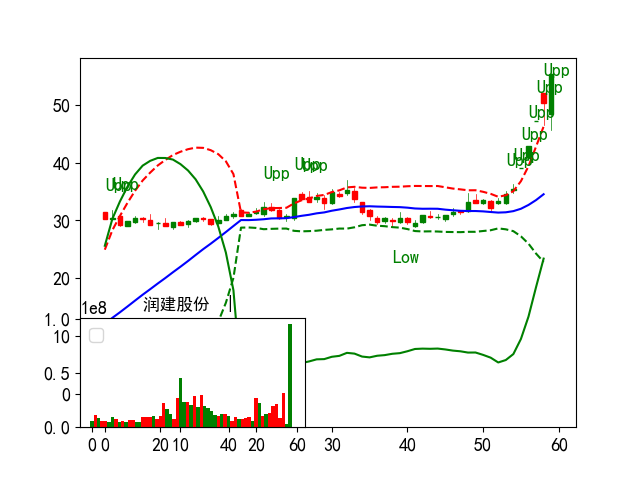

600387 0.0
xratio:-0.01 ra_diff:nan
code: 600387


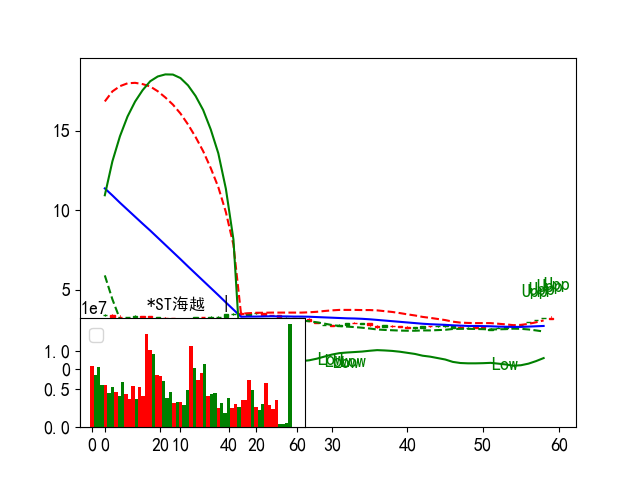

600633 0.0
xratio:0.04 ra_diff:nan
code: 600633


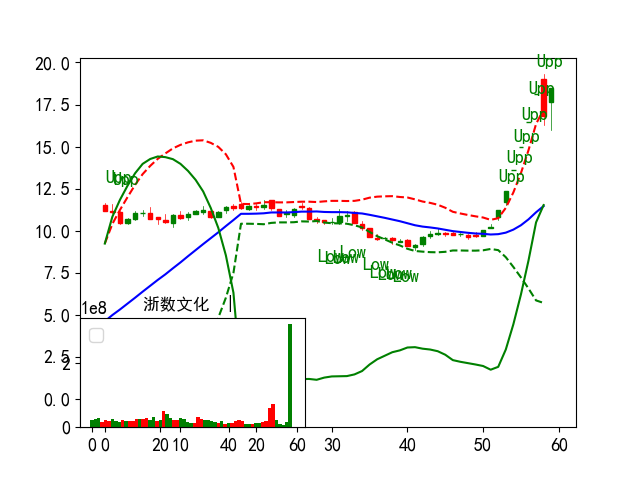

002016 0.0
xratio:-0.05 ra_diff:nan
code: 002016


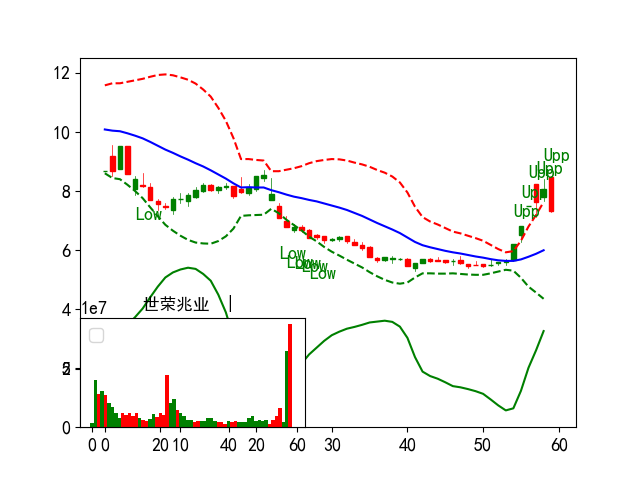

600126 0.0
xratio:0.06 ra_diff:nan
code: 600126


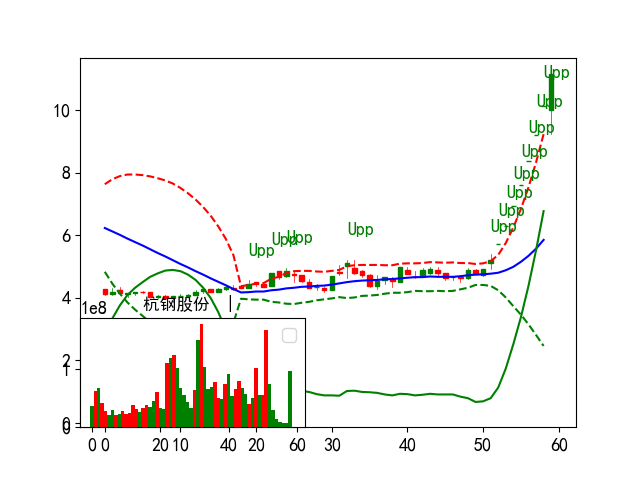

600081 0.0
xratio:0.0 ra_diff:nan
code: 600081


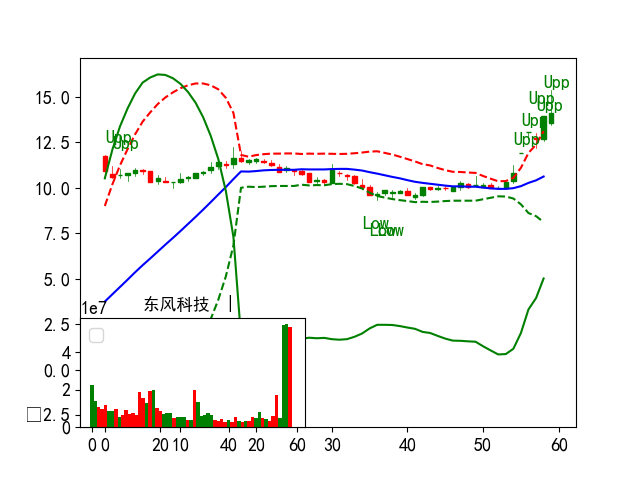

000818 0.0
xratio:0.01 ra_diff:nan
code: 000818


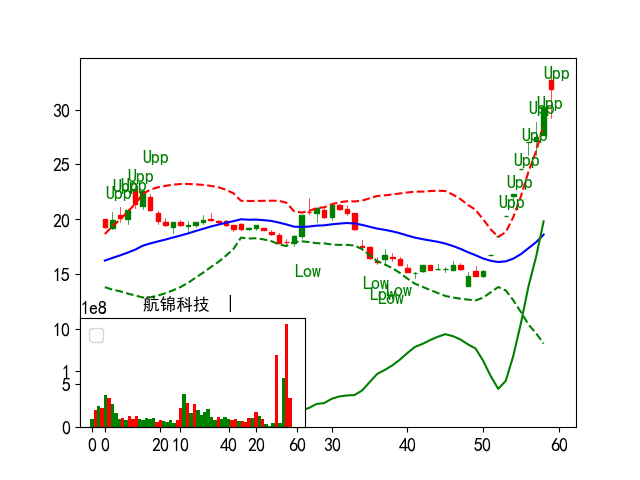

002123 0.0
xratio:0.07 ra_diff:nan
code: 002123


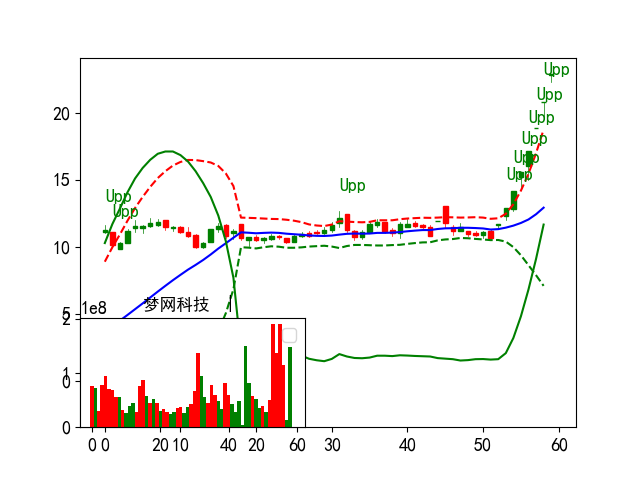

605398 0.0
xratio:0.28 ra_diff:nan
code: 605398


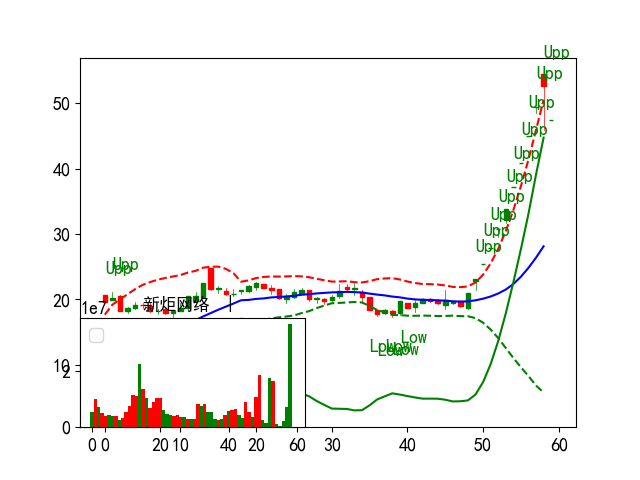

603881 0.0
xratio:0.15 ra_diff:nan
code: 603881


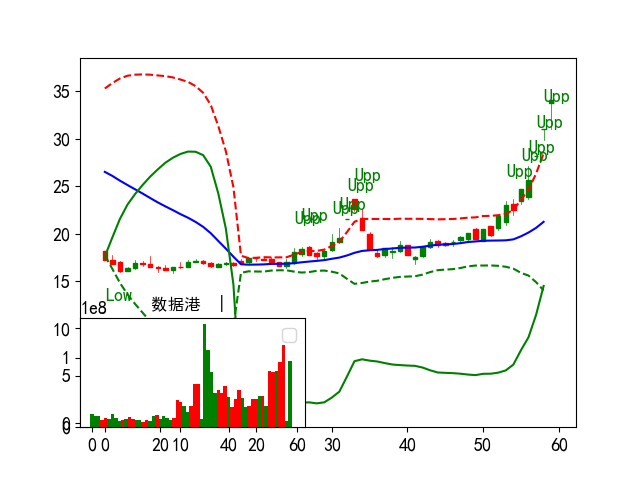

In [185]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:153
300530 0.0
xratio:-0.13 ra_diff:nan
code: 300530


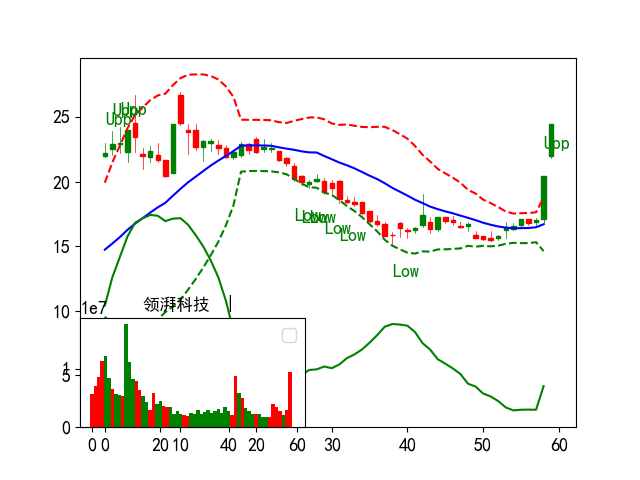

301396 0.0
xratio:0.08 ra_diff:nan
code: 301396


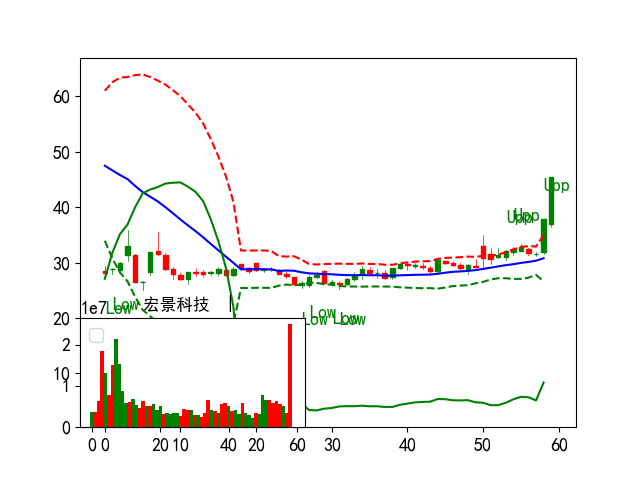

300816 0.0
xratio:0.02 ra_diff:nan
code: 300816


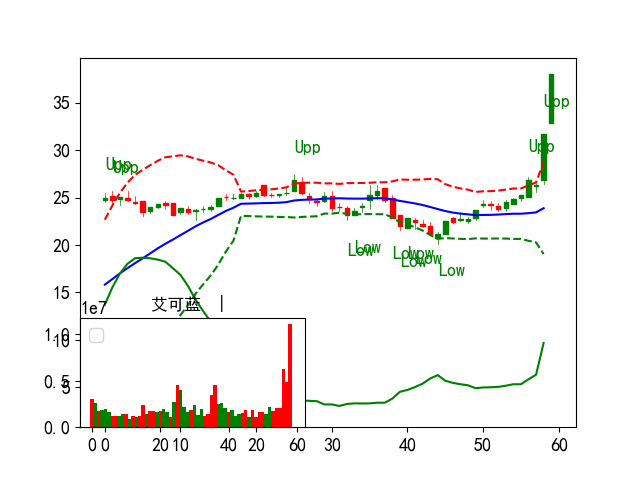

300249 0.0
xratio:0.09 ra_diff:nan
code: 300249


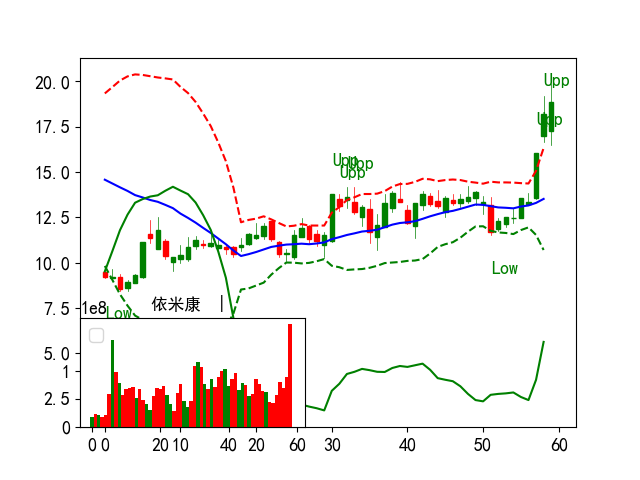

603956 0.0
xratio:0.0 ra_diff:nan
code: 603956


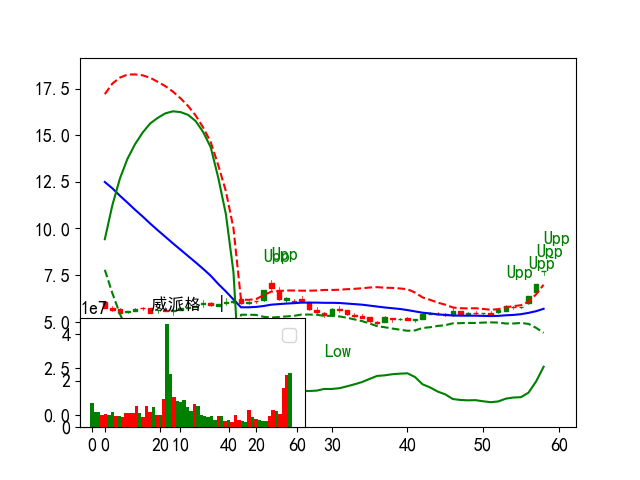

002123 0.0
xratio:0.07 ra_diff:nan
code: 002123


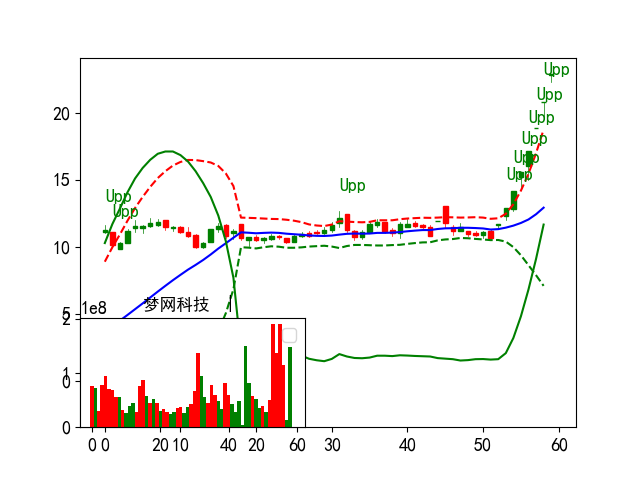

002691 0.0
xratio:0.07 ra_diff:nan
code: 002691


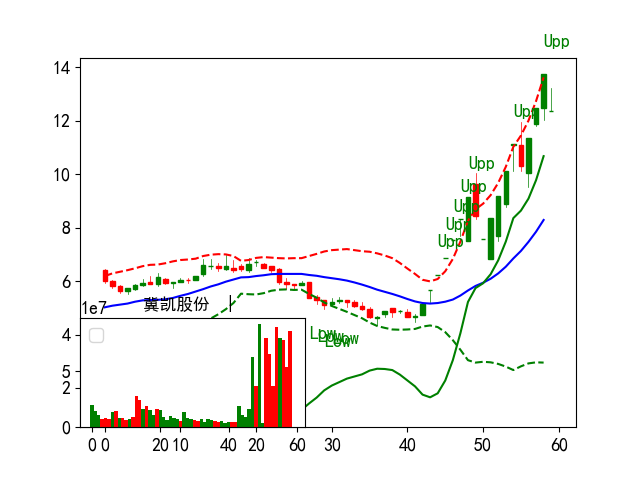

601116 0.0
xratio:-0.0 ra_diff:nan
code: 601116


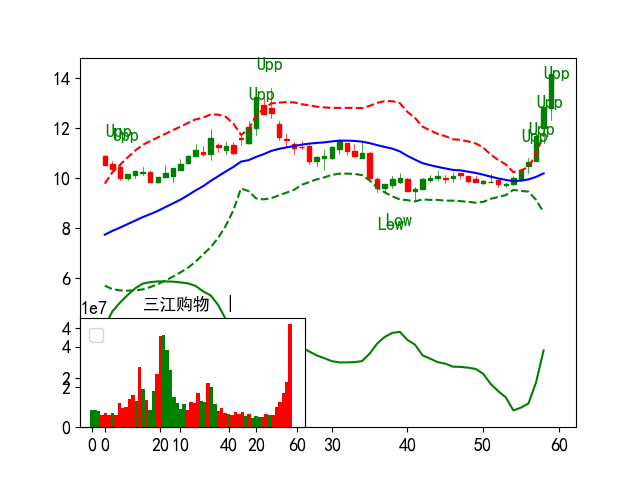

603881 0.0
xratio:0.15 ra_diff:nan
code: 603881


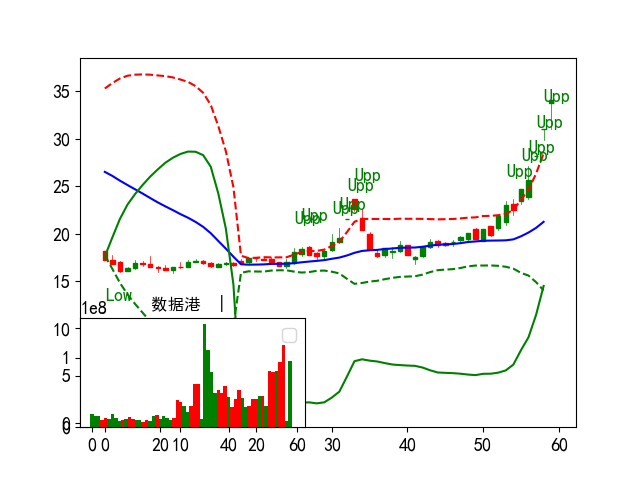

600126 0.0
xratio:0.06 ra_diff:nan
code: 600126


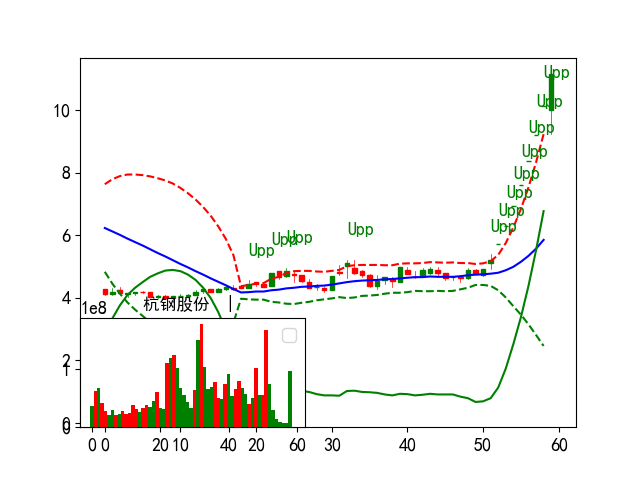

In [186]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [187]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250][:5])

cross_hamx:113
Count:5 41


name  couts       date   perc  ra_diff  xratio    idx  hat  close  \
code                                                                        
300530  领湃科技      2 2025-02-14  20.00      0.0    0.12   8.93  0.0  24.48   
301396  宏景科技      2 2025-02-14  19.99      0.0    0.37  14.71  0.0  45.50   
300816   艾可蓝      2 2025-02-14  19.99      0.0    0.32  13.66  0.0  37.99   
300249   依米康      2 2025-02-14   3.52      0.0    0.12   5.47  0.0  18.84   
603956   威派格      1 2025-02-14  10.00      0.0    0.09   3.02  0.0   8.47   

        volsum5d  ...  ma250     nclose   llow  vol1d   vol2d  vol3d   vol4d  \
code              ...                                                          
300530     125.1  ...    0.0  24.480000  21.80 -100.0  230.06  39.25  -26.68   
301396     489.9  ...    0.0  44.656018  36.40 -100.0  643.80 -35.14   -9.26   
300816     208.6  ...    0.0  37.990000  32.87 -100.0  128.79 -22.75  202.94   
300249      62.2  ...    0.0  18.169363  16.50 -100.0  106.85  26.71  -12.41   
603956     120.1  ...    0.0   8.470000   8.47 -100.0    3.93  31.17  202.31   

        vol5d  perc3d  perc5d  
code                           
300530 -17.50   45.63   47.83  
301396  -9.51   43.71   40.30  
300816  -0.41   41.54   52.94  
300249  41.03   40.91   51.20  
603956 -17.35   33.18   47.05  

[5 rows x 24 columns]

df_mask250:113
002343 0.0
xratio:-0.02 ra_diff:nan
code: 002343


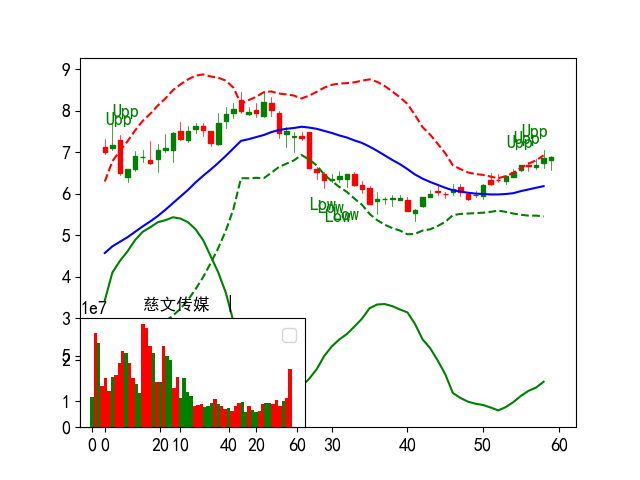

002508 0.0
xratio:-0.04 ra_diff:nan
code: 002508


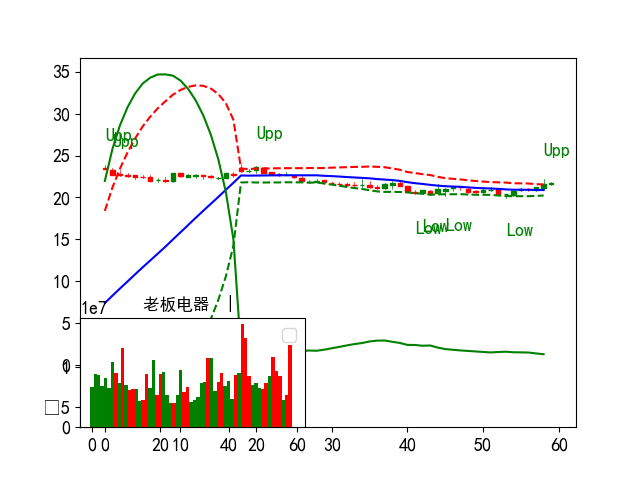

300374 0.0
xratio:-0.1 ra_diff:nan
code: 300374


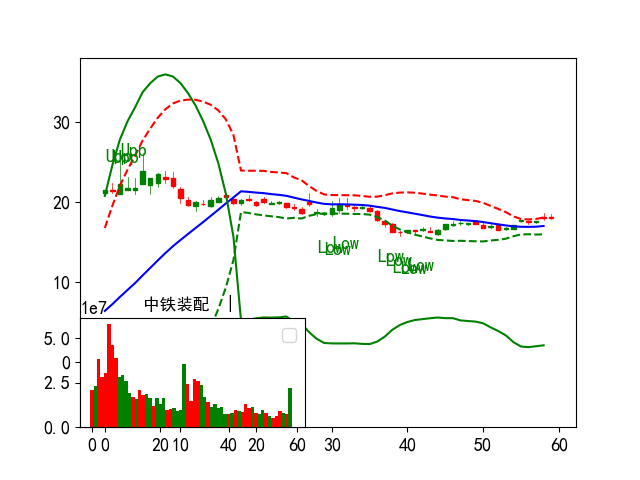

000860 0.0
xratio:-0.05 ra_diff:nan
code: 000860


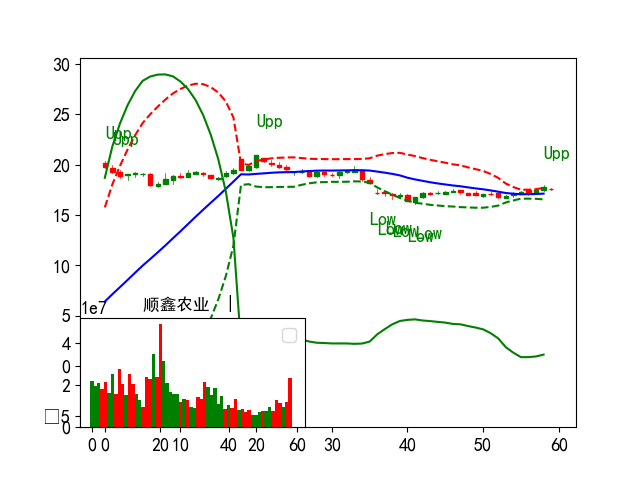

600233 0.0
xratio:-0.04 ra_diff:nan
code: 600233


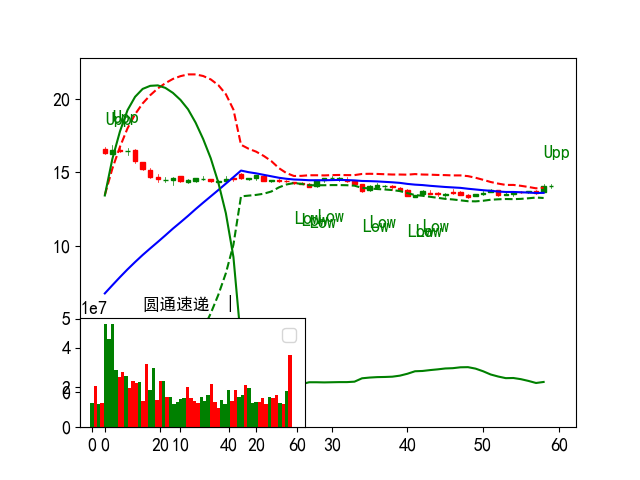

002932 0.0
xratio:-0.03 ra_diff:nan
code: 002932


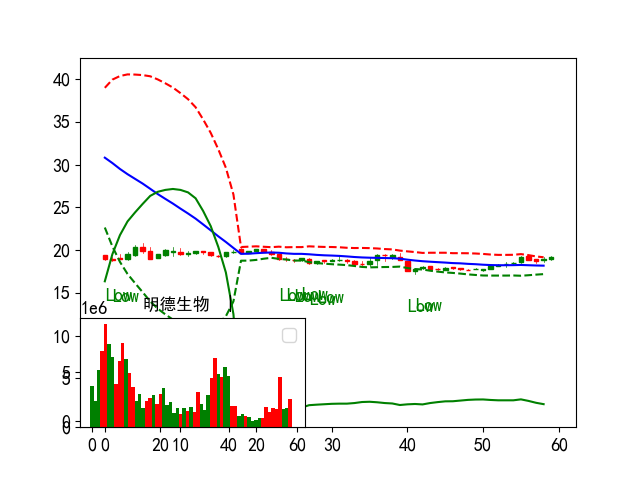

601728 0.0
xratio:0.01 ra_diff:nan
code: 601728


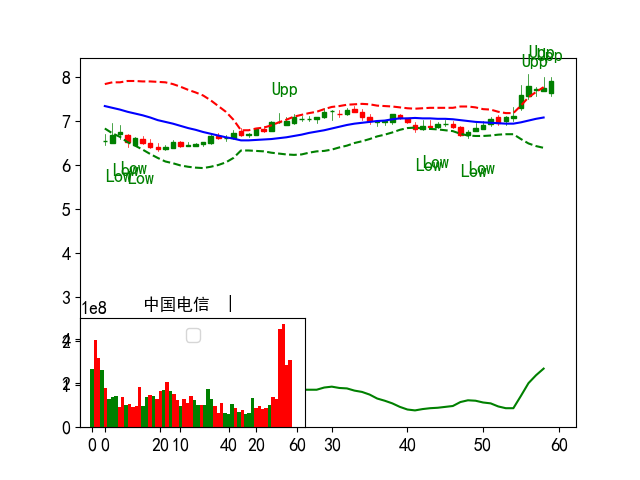

600846 0.0
xratio:-0.01 ra_diff:nan
code: 600846


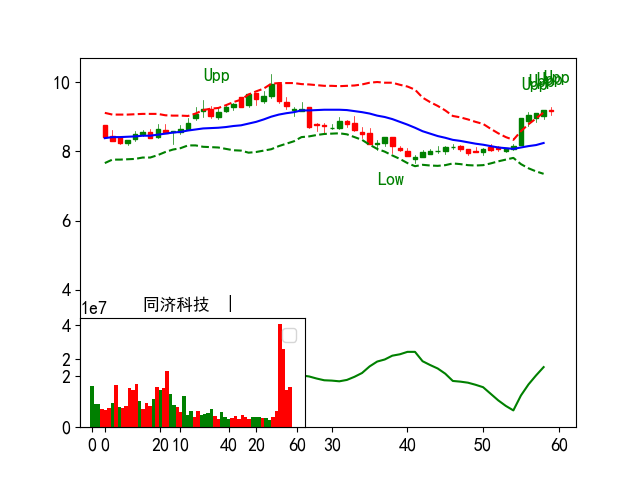

002995 0.0
xratio:-0.05 ra_diff:nan
code: 002995


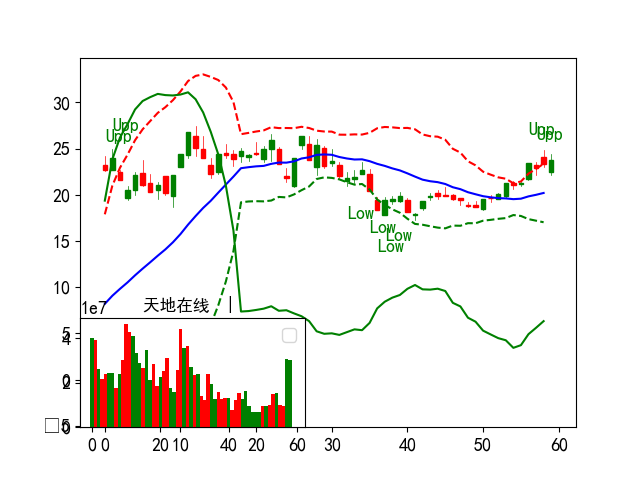

603803 0.0
xratio:0.06 ra_diff:nan
code: 603803


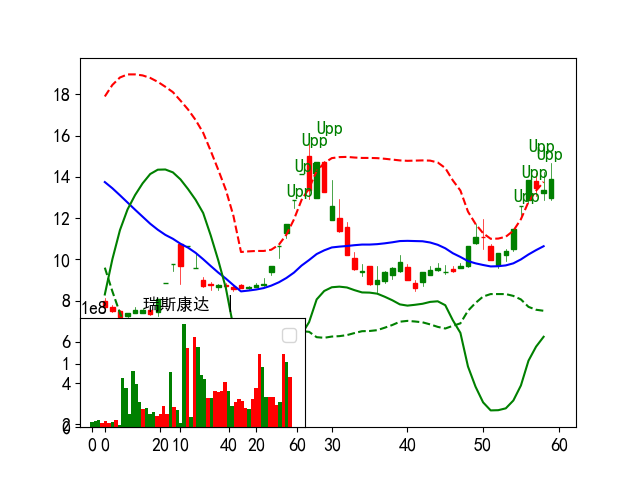

In [188]:
print("df_mask250:%s"%(len(cross_hmax_250)))
# dfs.loc['000002'].shape
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfsRoot.loc[co][-60:],code=co)

## 写入061

In [189]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [190]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [191]:
top_temp.shape
top_temp.index

(831, 34)

Index(['002801', '000887', '603416', '600114', '600489', '600580', '601689',
       '603666', '603809', '301171',
       ...
       '002561', '000695', '002339', '002275', '002216', '002173', '002166',
       '001211', '000721', '601888'],
      dtype='object', name='code', length=831)

## plt.close('all')

In [192]:
# plt.close('all')

# 写入060